In [53]:
import json
import os
import os.path
import pathlib
from typing import Any, Sequence, Tuple, Mapping

In [70]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
from rlplg.environments.gridworld import env, utils, constants
import text_to_image

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 12

### Grid World Grids

In [4]:
GRID_MAP_BASE_PATH = os.path.join(pathlib.Path.home(), "code", "rlplg", "assets", "env", "gridworld_cliff", "maps")

In [5]:
def grid_path(path: str, name: str):
    return os.path.join(path, f"{name}.txt")


def load_grid(path: str, name: str):
    with open(grid_path(path, name)) as readable:
        return [list(line.strip()) for line in readable]
    
    
def grid_as_string(grid: Sequence[Sequence[str]]):
    rows = []
    for row in grid:
        rows.append("".join(row))
    return "\n".join(rows)

In [6]:
load_grid(GRID_MAP_BASE_PATH, "gridworld_cliff_02")

[['o', 'o', 'o', 'x', 'o', 'o', 'o', 'o'],
 ['s', 'o', 'o', 'o', 'o', 'o', 'o', 'g']]

In [7]:
print(grid_as_string(load_grid(GRID_MAP_BASE_PATH, "gridworld_cliff_02")))

oooxoooo
soooooog


In [8]:
def position_state_mapping(grid_name: str):
    size, cliffs, _, _ = utils.parse_grid(path=grid_path(GRID_MAP_BASE_PATH, grid_name))
    return env.states_mapping(size=size, cliffs=cliffs)    

In [9]:
position_state_mapping("gridworld_cliff_02")

{(0, 0): 0,
 (0, 1): 1,
 (0, 2): 2,
 (0, 4): 3,
 (0, 5): 4,
 (0, 6): 5,
 (0, 7): 6,
 (1, 0): 7,
 (1, 1): 8,
 (1, 2): 9,
 (1, 3): 10,
 (1, 4): 11,
 (1, 5): 12,
 (1, 6): 13,
 (1, 7): 14}

### Counterfactual Run Results

In [10]:
BASE_RESULTS_PATH = os.path.join(pathlib.Path.home(), "fs/experiments/explain-rl/gridworld")

In [11]:
def create_state_path(base_path:str):
    def stats_path(grid_name: str, blackbox: str, control_fn: str, reward_fn: str, intervention_penalty: str, timestamp: int):
        """
        e.g. ../blackbox_dyna-prog/control-fn_q-learning/reward-fn_contrary-penalty-fn/1655279109/blackbox_counterfactual_stats.json
        """
        return os.path.join(base_path, grid_name, f"blackbox_{blackbox}", f"control-fn_{control_fn}", f"reward-fn_{reward_fn}", f"intervention-penalty_{intervention_penalty}", str(timestamp), "blackbox_counterfactual_stats.json")
    return stats_path

In [12]:
def load_blackbox_counterfactual_run_stats(path: str):
    with open(path, "r") as readable:
        data = {}
        for line in readable:
            record = json.loads(line)
            key = record["state"]
            del record["state"]
            data[key] = record["stats"]
        return data

In [13]:
stats_path = create_state_path(BASE_RESULTS_PATH)
load_blackbox_counterfactual_run_stats(stats_path("gridworld_cliff_05", blackbox="q-learning", control_fn="q-learning", reward_fn="counterfactual-reward-fn", intervention_penalty="off", timestamp=1655297189))

{0: {'blackbox_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_intervention_prob': 0.0},
 1: {'blackbox_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_intervention_prob': 0.0},
 2: {'blackbox_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_intervention_prob': 0.0},
 3: {'blackbox_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_intervention_prob': 0.0},
 4: {'blackbox_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_intervention_prob': 0.0},
 5: {'blackbox_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_intervention_prob': 0.0},
 6: {'blackbox_policy_action_stats': {'1': 1.0},
  'counterfactual_policy_action_stats':

In [81]:
def visualise_stats(grid_name: str, stats_path: str):
    grid = load_grid(GRID_MAP_BASE_PATH, grid_name)
    pos_state = position_state_mapping(grid_name)
    state_pos = {value: key for key, value in pos_state.items()}
    stats = load_blackbox_counterfactual_run_stats(stats_path)
    base_grid = np.array(grid)
    blackbox_grid = np.copy(base_grid)
    counterfactual_grid = np.copy(base_grid)
    intervention_prob = np.zeros_like(base_grid, dtype=np.float32)
        
    print(f"**Grid**: \n{grid_as_string(grid)}")
    for state, info in stats.items():
        coord = state_pos[state]
        intervention_prob[coord] = info["counterfactual_policy_intervention_prob"]
        # if there is a record, there was an intervention
        blackbox_top_action = policy_greedy_action(info["blackbox_policy_action_stats"])
        counterfactual_top_action = policy_greedy_action(info["counterfactual_policy_action_stats"])
        blackbox_grid[coord] = constants.MOVE_SYMBOLS[blackbox_top_action]
        if intervention_prob[coord] > 0:
            counterfactual_grid[coord] = constants.MOVE_SYMBOLS[counterfactual_top_action]
        # print("blackbox-stats", state, coord, info["blackbox_policy_action_stats"])
        # print("counterfactual-stats", state, coord, info["counterfactual_policy_action_stats"], f"p({intervention_prob[coord]})")
    
    
    print(f"**Blackbox Action**: \n{blackbox_grid}")
    print(f"**Counterfactual Overrides**: \n{counterfactual_grid}")
    fig, ax = plt.subplots()
    sns.heatmap(intervention_prob, annot=True, fmt=".1f", ax=ax)
    #add overall title to replot
    fig.suptitle("Intervention Probability")
    return ax


def policy_greedy_action(stats: Mapping[str, float]):
    actions = sorted([int(action) for action in stats.keys()])
    probs = [stats[str(key)] for key in actions]
    top_action = np.argmax(probs)
    return actions[top_action]

In [15]:
def export_figure(ax, name: str, format: str = "pdf", dpi=300, transparent: bool = True):
    # to be able to save, we must plot
    _ = ax.plot()
    base_dir = os.path.dirname(name)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    plt.savefig(f"{name}.{format}", dpi=dpi, format=format, transparent=transparent)

In [16]:
TIMESTAMP = 1655299859

## Same Reward Fn

## Gridworld 3

**No intervention penalty**

**Grid**: 
|o|o|o|o|o|o|o|o|
|o|o|x|o|o|o|o|g|
|s|o|o|o|o|x|o|o|
**Blackbox Action**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'x' 'o' '→' '→' '→' 'g']
 ['→' '→' '→' '→' '↑' 'x' 'o' 'o']]
**Counterfactual Overrides**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'x' 'o' 'o' 'o' 'o' 'g']
 ['s' 'o' 'o' 'o' 'o' 'x' 'o' 'o']]


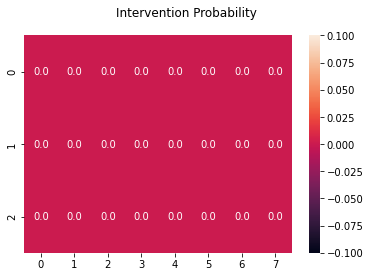

In [83]:
ax = visualise_stats("gridworld_cliff_03", stats_path("gridworld_cliff_03", blackbox="q-learning", control_fn="q-learning", reward_fn="same-fn", intervention_penalty="off", timestamp=TIMESTAMP))
export_figure(ax, name="figures/same-fn_gridworld-cliff-03_intervention-penalty-off")

**With intervention penalty**

**Grid**: 
oooooooo
ooxoooog
sooooxoo
**Blackbox Action**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'x' 'o' '→' '→' '→' 'g']
 ['→' '→' '→' '→' '↑' 'x' 'o' 'o']]
**Counterfactual Overrides**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'x' 'o' 'o' 'o' 'o' 'g']
 ['s' 'o' 'o' 'o' 'o' 'x' 'o' 'o']]


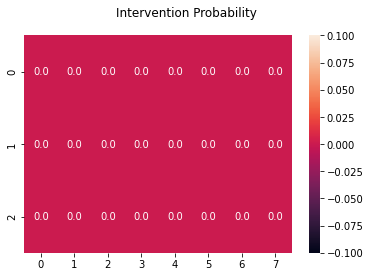

In [18]:
ax = visualise_stats("gridworld_cliff_03", stats_path("gridworld_cliff_03", blackbox="q-learning", control_fn="q-learning", reward_fn="same-fn", intervention_penalty="on", timestamp=TIMESTAMP))
export_figure(ax, name="figures/same-fn_gridworld-cliff-03_intervention-penalty-on")

## Gridworld 5

**No intervention penalty**

**Grid**: 
oooooooo
oooooooo
sxxxxxxg
**Blackbox Action**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]
**Counterfactual Overrides**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['s' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]


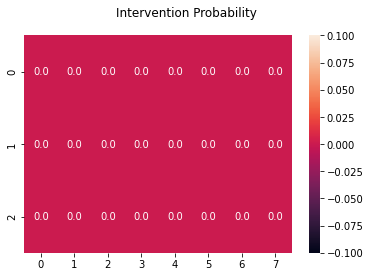

In [19]:
ax = visualise_stats("gridworld_cliff_05", stats_path("gridworld_cliff_05", blackbox="q-learning", control_fn="q-learning", reward_fn="same-fn", intervention_penalty="off", timestamp=TIMESTAMP))
export_figure(ax, name="figures/same-fn_gridworld-cliff-05_intervention-penalty-off")

**With intervention penalty**

**Grid**: 
oooooooo
oooooooo
sxxxxxxg
**Blackbox Action**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]
**Counterfactual Overrides**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['s' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]


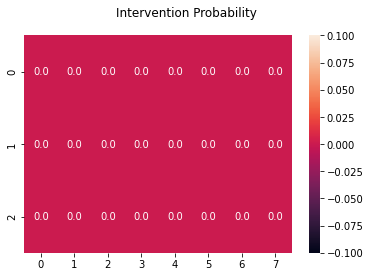

In [20]:
ax = visualise_stats("gridworld_cliff_05", stats_path("gridworld_cliff_05", blackbox="q-learning", control_fn="q-learning", reward_fn="same-fn", intervention_penalty="on", timestamp=TIMESTAMP))
export_figure(ax, name="figures/same-fn_gridworld-cliff-05_intervention-penalty-on")

## Gridworld 7

**No intervention penalty**

**Grid**: 
ooxooxooooo
xoooooooooo
oooooooooox
ooooooooooo
oooooxooooo
soxooooooog
**Blackbox Action**: 
[['o' 'o' 'x' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' '→' '→' '→' '↓' 'x' 'o' 'o' 'o' 'o' 'o']
 ['→' '↑' 'x' 'o' '→' '→' '→' '→' '→' '→' 'g']]
**Counterfactual Overrides**: 
[['o' 'o' 'x' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['s' 'o' 'x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'g']]


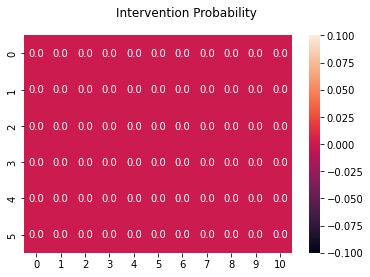

In [21]:
ax = visualise_stats("gridworld_cliff_07", stats_path("gridworld_cliff_07", blackbox="q-learning", control_fn="q-learning", reward_fn="same-fn", intervention_penalty="off", timestamp=TIMESTAMP))
export_figure(ax, name="figures/same-fn_gridworld-cliff-07_intervention-penalty-off")

**With intervention penalty**

**Grid**: 
ooxooxooooo
xoooooooooo
oooooooooox
ooooooooooo
oooooxooooo
soxooooooog
**Blackbox Action**: 
[['o' 'o' 'x' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' '→' '→' '→' '↓' 'x' 'o' 'o' 'o' 'o' 'o']
 ['→' '↑' 'x' 'o' '→' '→' '→' '→' '→' '→' 'g']]
**Counterfactual Overrides**: 
[['o' 'o' 'x' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['s' 'o' 'x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'g']]


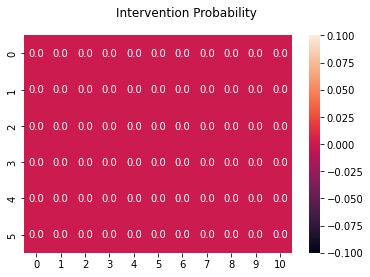

In [22]:
visualise_stats("gridworld_cliff_07", stats_path("gridworld_cliff_07", blackbox="q-learning", control_fn="q-learning", reward_fn="same-fn", intervention_penalty="on", timestamp=TIMESTAMP))
export_figure(ax, name="figures/same-fn_gridworld-cliff-07_intervention-penalty-on")

## Counterfactual Reward Fn: Penalises being close to the cliff

## Gridworld 3

**No intervention penalty**

**Grid**: 
oooooooo
ooxoooog
sooooxoo
**Blackbox Action**: 
[['o' 'o' 'o' '↓' '↓' '↓' '↓' '↓']
 ['o' 'o' 'x' '→' '→' '→' '→' 'g']
 ['→' '→' '→' '→' '↑' 'x' 'o' 'o']]
**Counterfactual Overrides**: 
[['o' 'o' 'o' '→' '→' '→' '→' 'o']
 ['o' 'o' 'x' '↑' 'o' 'o' 'o' 'g']
 ['s' 'o' 'o' '↑' 'o' 'x' 'o' 'o']]


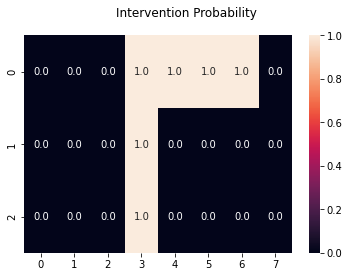

In [23]:
ax = visualise_stats("gridworld_cliff_03", stats_path("gridworld_cliff_03", blackbox="q-learning", control_fn="q-learning", reward_fn="counterfactual-reward-fn", intervention_penalty="off", timestamp=TIMESTAMP))
export_figure(ax, name="figures/counterfactual-reward-fn_gridworld-cliff-03_intervention-penalty-off")

**With intervention penalty**

**Grid**: 
oooooooo
ooxoooog
sooooxoo
**Blackbox Action**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'x' 'o' '→' '→' '→' 'g']
 ['→' '→' '→' '→' '↑' 'x' 'o' 'o']]
**Counterfactual Overrides**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'x' 'o' 'o' 'o' 'o' 'g']
 ['s' 'o' 'o' 'o' 'o' 'x' 'o' 'o']]


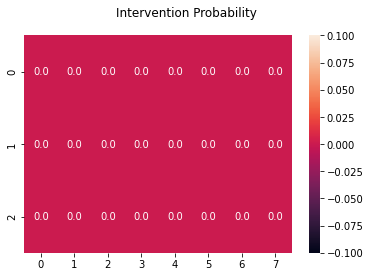

In [24]:
ax = visualise_stats("gridworld_cliff_03", stats_path("gridworld_cliff_03", blackbox="q-learning", control_fn="q-learning", reward_fn="counterfactual-reward-fn", intervention_penalty="on", timestamp=TIMESTAMP))
export_figure(ax, name="figures/counterfactual-reward-fn_gridworld-cliff-03_intervention-penalty-on")

## Gridworld 5

**No intervention penalty**

**Grid**: 
oooooooo
oooooooo
sxxxxxxg
**Blackbox Action**: 
[['↓' '→' '→' '↓' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]
**Counterfactual Overrides**: 
[['→' 'o' 'o' '→' '→' '→' '→' 'o']
 ['↑' '↑' 'o' '↑' 'o' 'o' 'o' 'o']
 ['s' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]


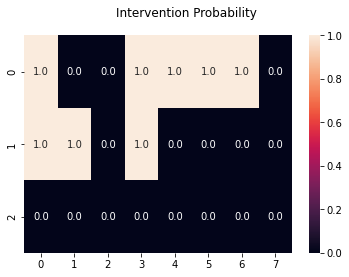

In [25]:
ax = visualise_stats("gridworld_cliff_05", stats_path("gridworld_cliff_05", blackbox="q-learning", control_fn="q-learning", reward_fn="counterfactual-reward-fn", intervention_penalty="off", timestamp=TIMESTAMP))
export_figure(ax, name="figures/counterfactual-reward-fn_gridworld-cliff-05_intervention-penalty-off")

**With intervention penalty**

**Grid**: 
oooooooo
oooooooo
sxxxxxxg
**Blackbox Action**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]
**Counterfactual Overrides**: 
[['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['s' 'x' 'x' 'x' 'x' 'x' 'x' 'g']]


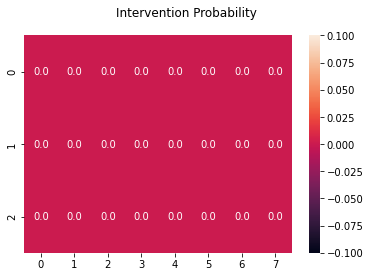

In [26]:
ax = visualise_stats("gridworld_cliff_05", stats_path("gridworld_cliff_05", blackbox="q-learning", control_fn="q-learning", reward_fn="counterfactual-reward-fn", intervention_penalty="on", timestamp=TIMESTAMP))
export_figure(ax, name="figures/counterfactual-reward-fn_gridworld-cliff-05_intervention-penalty-on")

## Gridworld 7

**No intervention penalty**

**Grid**: 
ooxooxooooo
xoooooooooo
oooooooooox
ooooooooooo
oooooxooooo
soxooooooog
**Blackbox Action**: 
[['o' 'o' 'x' '→' '←' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' '→' '→' '←' '↑' '→' '→' '→' '↓' 'o' 'o']
 ['↓' '↑' '→' '→' '→' '↑' '↓' '→' '→' '↓' 'x']
 ['↑' '→' '→' '→' '→' '→' '→' '→' '↓' '→' '↓']
 ['→' '→' '→' '→' '↓' 'x' 'o' '↓' '↓' '→' '↓']
 ['→' '↑' 'x' '→' '→' '→' '→' '→' '→' '→' 'g']]
**Counterfactual Overrides**: 
[['o' 'o' 'x' '↓' '↓' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' '↓' 'o' '→' '→' '↓' '↓' '↓' 'o' 'o' 'o']
 ['→' '→' 'o' 'o' 'o' '→' '→' '↓' '↓' 'o' 'x']
 ['→' '↑' 'o' 'o' 'o' 'o' 'o' '↓' '→' '↓' 'o']
 ['↑' 'o' 'o' '↓' 'o' 'x' 'o' '→' '→' '↓' 'o']
 ['↑' 'o' 'x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'g']]


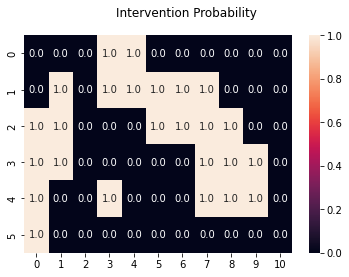

In [27]:
ax = visualise_stats("gridworld_cliff_07", stats_path("gridworld_cliff_07", blackbox="q-learning", control_fn="q-learning", reward_fn="counterfactual-reward-fn", intervention_penalty="off", timestamp=TIMESTAMP))
export_figure(ax, name="figures/counterfactual-reward-fn_gridworld-cliff-07_intervention-penalty-off")

**With intervention penalty**

**Grid**: 
ooxooxooooo
xoooooooooo
oooooooooox
ooooooooooo
oooooxooooo
soxooooooog
**Blackbox Action**: 
[['o' 'o' 'x' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['→' '→' '→' '→' '↓' 'x' 'o' 'o' 'o' 'o' 'o']
 ['→' '↑' 'x' 'o' '→' '→' '→' '→' '→' '→' 'g']]
**Counterfactual Overrides**: 
[['o' 'o' 'x' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'x' 'o' 'o' 'o' 'o' 'o']
 ['↑' 'o' 'x' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'g']]


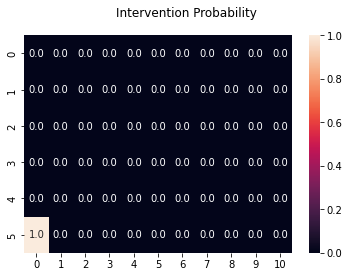

In [28]:
ax = visualise_stats("gridworld_cliff_07", stats_path("gridworld_cliff_07", blackbox="q-learning", control_fn="q-learning", reward_fn="counterfactual-reward-fn", intervention_penalty="on", timestamp=TIMESTAMP))
export_figure(ax, name="figures/counterfactual-reward-fn_gridworld-cliff-07_intervention-penalty-on")